# Задача 6. Компьютерное зрение: задача сегментации

Обучаем Сегментацию:

- https://drive.google.com/file/d/11wp4Bm-hEVwmZq8GmqbLpKpJiqvDSNAe/view?usp=sharing --- тут лежит датасет который мы будем использовать.


- **Сделать train/test split** (или кросс-валидацию), **зафиксировать все сиды** чтобы более-менее воспроизводились результаты. **Добавить метрику jaccard index**. **Переобучиться на одном батче** (например 4 картинки), попробовать получить почти идеальное качество, посмотреть получилось или нет. **Посчитать метрики для батча и для теста**. Обучить на всем train, построить train/val кривые для loss и для jaccard index, подобрать оптимальное время обучения (количество шагов) для фиксированных параметров. Визуализировать topN самых плохих предсказаний.
- Попробовать улучшить качество не меняя архитектуру: аугментации, гиперпараметры. Сделать test time аугментации через horizontal flip, посмотреть улучшается ли что-то.
- Попробовать улучшить качество изменяя архитектуру.
* (+2 балла) Сделать train/test разбиение. Внутри train сделать 5fold, обучить 5 моделей. Построить кривые обучения для каждого фолда. Предсказать тест со всех 5 моделей и сагрегировать предсказания (до расчета метрик), сравнить с одной моделью обученной на всех данных. Сравнить с моделями обученными на фолдах. Сравнить плохие предсказания теста на разных фолдах. Ошибается на одних и тех же семплах или на разных?

In [2]:
device = "cuda"

## Подготовка данных

In [3]:
!unzip '/content/drive/MyDrive/dataset.zip'

Archive:  /content/drive/MyDrive/dataset.zip
replace dataset/masks/1803262049-00000501.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [4]:
!ls '/content/dataset'

images	masks


In [5]:
!pip install torchmetrics -U

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 115.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 37.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [24]:
import copy
import random
import cv2
import functools
import torch
import torchmetrics
import pandas as pd
import seaborn as sns
import torchvision.transforms as transforms
import numpy as np

from pathlib import Path
from matplotlib import pyplot as plt
from tqdm.auto import tqdm, trange
from torch.optim import Adam
from glob import glob
from torch import nn
from torchvision.transforms import functional
from torch.utils.data import Dataset, ConcatDataset, DataLoader
from torchvision import io
from IPython.display import clear_output
import warnings
from sklearn.model_selection import KFold
from torch.utils.data import Dataset, DataLoader

In [6]:
np.random.seed(123)

In [12]:
image_prepare = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
])

class Dataset(torch.utils.data.Dataset):
    def __init__(self, images, masks, transform=image_prepare):
        self.images = images
        self.masks = masks

        assert len(self.images) == len(self.masks)

        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, item):
        img = self.transform(io.read_image(str(self.images[item])))
        mask = self.transform(io.read_image(str(self.masks[item])))
        return img, mask

In [9]:
images_path = np.array(sorted(Path("dataset/images").iterdir()))
masks_path = np.array(sorted(Path("dataset/masks").iterdir()))

In [10]:
train_size = int(len(images_path) * 0.8)

test_dataset = Dataset(images=images_path[train_size:], masks=masks_path[train_size:])
train_dataset = Dataset(images=images_path[:train_size], masks=masks_path[:train_size])

In [11]:
print("Train size:", len(train_dataset))
print("Test size:", len(test_dataset))

Train size: 1600
Test size: 400


In [10]:
def show_images(image, mask):
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(functional.to_pil_image(image))
    ax[1].imshow(functional.to_pil_image(mask))

torch.Size([3, 800, 600])
torch.Size([1, 800, 600])


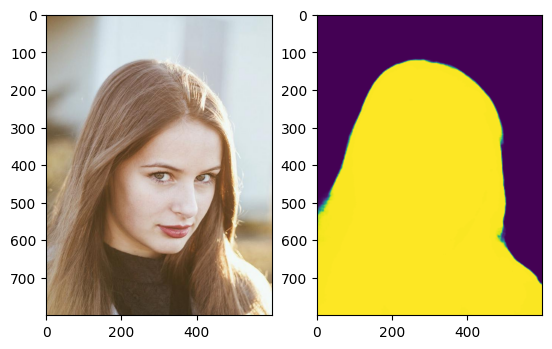

In [13]:
random_mask = np.random.choice(len(images_path), size=len(images_path), replace=True)

image, mask = train_dataset[60]
print(image.shape)
print(mask.shape)
show_images(image, mask)

## Построение U-Net

In [30]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=0):
        super(CNNBlock, self).__init__()

        self.seq_block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True))

    def forward(self, x):
        return self.seq_block(x)


class CNNBlocks(nn.Module):
    def __init__(self, n_conv, in_channels, out_channels, padding):
          super(CNNBlocks, self).__init__()

          self.layers = nn.ModuleList()
          for _ in range(n_conv):
              self.layers.append(CNNBlock(in_channels, out_channels, padding=padding))
              in_channels = out_channels

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


class Encoder(nn.Module):
    def __init__(self, in_channels, out_channels, padding, n_down=4):
        super(Encoder, self).__init__()

        self.enc_layers = nn.ModuleList()
        for _ in range(n_down):
            self.enc_layers += [CNNBlocks(n_conv=2,
                                          in_channels=in_channels,
                                          out_channels=out_channels,
                                          padding=padding),
                                nn.MaxPool2d(2, 2)
                                ]

            in_channels = out_channels
            out_channels = 2 * out_channels

        self.enc_layers.append(CNNBlocks(n_conv=2,
                                         in_channels=in_channels,
                                         out_channels=out_channels,
                                         padding=padding
                                         ))

    def forward(self, x):
        connections = []
        for layer in self.enc_layers:
            if isinstance(layer, CNNBlocks):
                x = layer(x)
                connections.append(x)
            else:
                x = layer(x)
        return x, connections


class Decoder(nn.Module):
    def __init__(self, in_channels, out_channels, exit_channels, padding, n_up=4):
        super(Decoder, self).__init__()

        self.exit_channels = exit_channels
        self.layers = nn.ModuleList()

        for i in range(n_up):
            self.layers += [nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
                            CNNBlocks(n_conv=2, in_channels=in_channels, out_channels=out_channels, padding=padding)]

            in_channels //= 2
            out_channels //= 2

        self.layers.append(nn.Conv2d(in_channels, self.exit_channels, kernel_size=1, padding=0))

    def forward(self, x, connections):
        connections.pop(-1)
        for layer in self.layers:
            if isinstance(layer, CNNBlocks):
                connections_current = connections.pop(-1)
                dim_4 = connections_current.size(3) - x.size(3)
                dim_3 = connections_current.size(2) - x.size(2)
                if dim_4 != 0 or dim_3 != 0:
                    x = nn.functional.pad(x, [0, dim_4, 0, dim_3])
                x = torch.cat([x, connections_current], dim=1)
                x = layer(x)
            else:
                x = layer(x)
        return x

class UNET(nn.Module):
    def __init__(self, in_channels, first_out_channels, exit_channels, n_down=4, padding=1):
        super(UNET, self).__init__()
        self.encoder = Encoder(in_channels, first_out_channels, padding=padding, n_down=n_down)
        self.decoder = Decoder(first_out_channels * (2 ** n_down),
                               first_out_channels * (2 ** (n_down - 1)),
                               exit_channels, padding=padding, n_up=n_down)

    def forward(self, x):
        enc_out, connections = self.encoder(x)
        return self.decoder(enc_out, connections)

## Обучение

In [19]:
criterion = nn.BCEWithLogitsLoss()
jaccard = torchmetrics.classification.BinaryJaccardIndex().to(device)

def jaccard_index(pred, y):
    return jaccard(pred, y > jaccard.threshold)

In [20]:
def train(model, opt, loader, criterion, metric):
    model.train()

    losses_tr = []
    metric_tr = []

    for img_batch, mask_batch in tqdm(loader):
        img_batch, mask_batch = img_batch.to(device), mask_batch.to(device)

        pred = model(img_batch)
        loss = criterion(pred, mask_batch)
        metr = metric(pred, mask_batch)

        opt.zero_grad()
        loss.backward()
        opt.step()

        losses_tr.append(loss.item())
        metric_tr.append(metr.item())

    return model, opt, np.mean(losses_tr), np.mean(metric_tr)


def val(model, loader, criterion, metric):
    model.eval()

    losses_val = []
    metric_val = []

    with torch.no_grad():
        for img_batch, mask_batch in tqdm(loader):
            img_batch, mask_batch = img_batch.to(device), mask_batch.to(device)
            pred = model(img_batch)
            loss = criterion(pred, mask_batch)
            metr = metric(pred, mask_batch)

            losses_val.append(loss.item())
            metric_val.append(metr.item())

    return np.mean(losses_val), np.mean(metric_val)


def learning_loop(
    model,
    optimizer,
    train_loader,
    val_loader,
    criterion,
    epochs=10,
    val_every=1,
    draw_every=1,
    metric=jaccard_index
):

    losses = {'train': [], 'val': []}
    metrics = {'train': [], 'val': []}
    lrs = []

    for epoch in range(1, epochs+1):
        print(f'epoch #{epoch}/{epochs}:')

        model, optimizer, loss, metric_ = train(model, optimizer, train_loader, criterion, metric)
        losses['train'].append(loss)
        metrics['train'].append(metric_)

        loss, metric_ = val(model, val_loader, criterion, metric)
        losses['val'].append(loss)
        metrics['val'].append(metric_)

        clear_output(True)
        print(f"Train Loss: {losses['train'][-1]:.4f}, Val Loss: {losses['val'][-1]:.4f}")
        print(f"Train Metric: {metrics['train'][-1]:.4f}, Val Metric: {metrics['val'][-1]:.4f}")

        plt.figure(figsize=(16, 6))

        plt.subplot(1, 2, 1)
        plt.plot(losses['train'], 'r.-', label='Train Loss')
        plt.plot(losses['val'], 'g.-', label='Val Loss')
        plt.title('Loss over epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(metrics['train'], 'r.-', label='Train Metric')
        plt.plot(metrics['val'], 'g.-', label='Val Metric')
        plt.title(f'{metric.__name__ if callable(metric) else "Metric"} over epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Metric')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend()

        plt.tight_layout()
        plt.show()

    return model, optimizer, losses

Сначала обучим батч из 4 картинок

In [17]:
batch_size = 4

train_loader = torch.utils.data.DataLoader(
    torch.utils.data.Subset(train_dataset, range(batch_size)),
    batch_size=batch_size,
)
test_loader = torch.utils.data.DataLoader(
    torch.utils.data.Subset(test_dataset, range(batch_size)),
    batch_size=batch_size,
)

Train Loss: 0.2477, Val Loss: 1.0292
Train Metric: 0.9885, Val Metric: 0.3216


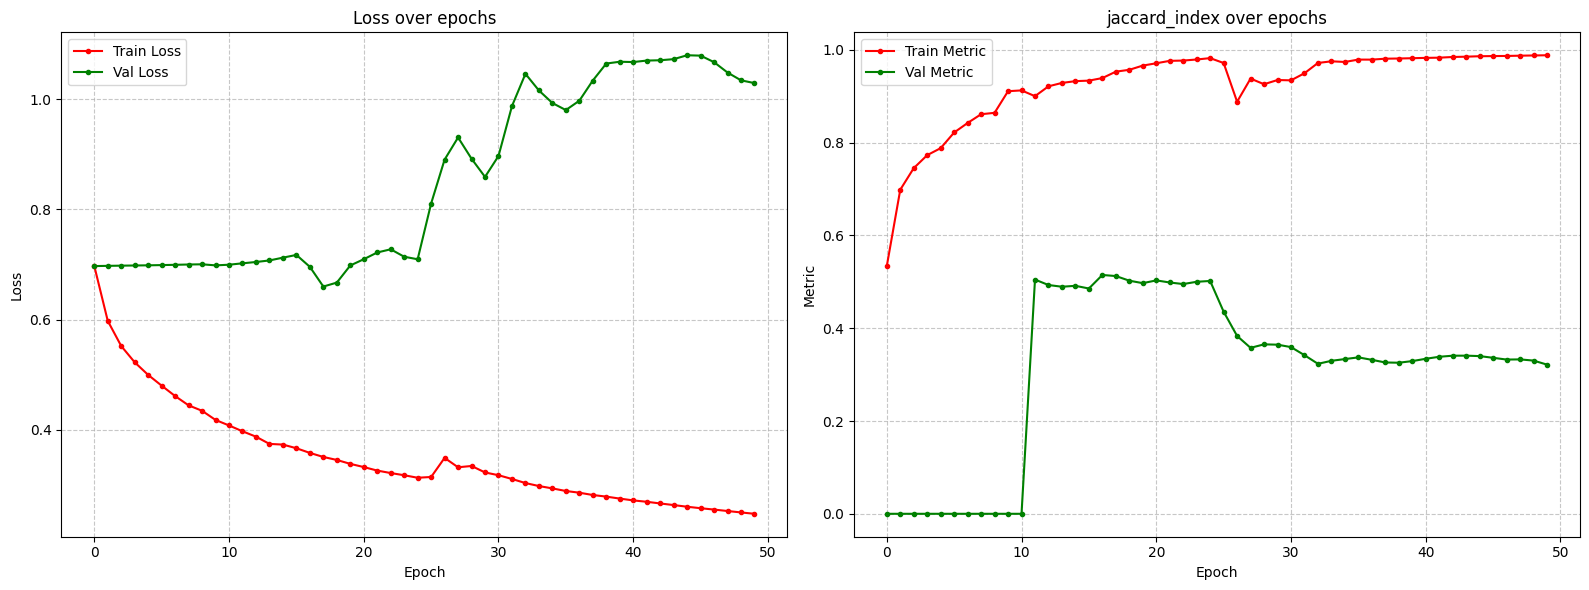

In [18]:
model = UNET(3, 16, 1).to(device)
optimizer = torch.optim.Adam(model.parameters())

model, _, _ = learning_loop(
    model, optimizer, train_loader, test_loader, criterion,
    epochs=50
)

Посмотрим результаты на train и test выборке.

In [19]:
model.eval();

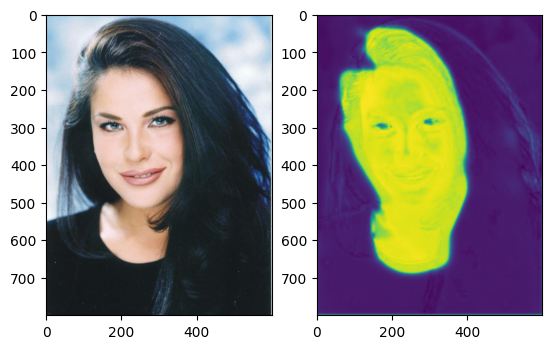

In [20]:
X, _ = train_dataset[15]
with torch.no_grad():
    pred = model(X.to(device).unsqueeze(0))[0].cpu()
show_images(X, nn.functional.sigmoid(pred))

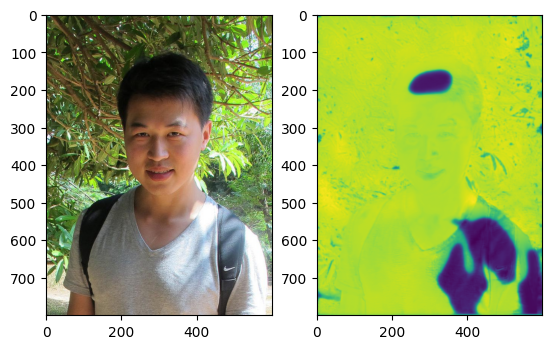

In [21]:
X, _ = test_dataset[15]

with torch.no_grad():
    pred = model(X.to(device).unsqueeze(0))[0].cpu()
show_images(X, nn.functional.sigmoid(pred))

Можно заметить, что на новых данных модель может плохо работать (переобучилась)

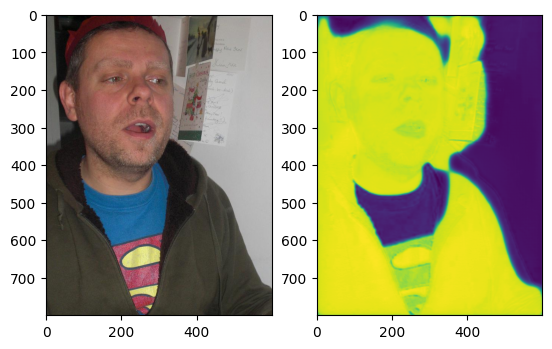

In [22]:
X, _ = test_dataset[16]

with torch.no_grad():
    pred = model(X.to(device).unsqueeze(0))[0].cpu()
show_images(X, nn.functional.sigmoid(pred))

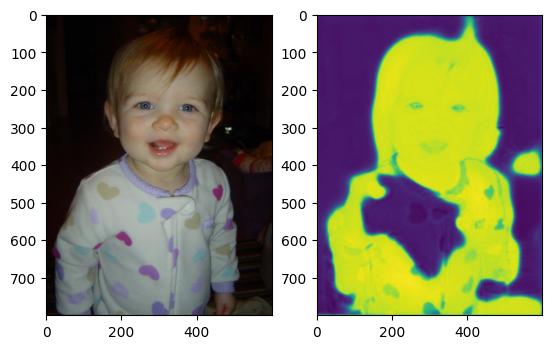

In [23]:
X, _ = test_dataset[17]

with torch.no_grad():
    pred = model(X.to(device).unsqueeze(0))[0].cpu()
show_images(X, nn.functional.sigmoid(pred))

Качество не идеальное, но уже что-то


Обучимся на всем датасете

In [24]:
batch_size = 4

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

Train Loss: 0.1958, Val Loss: 0.1957
Train Metric: 0.8617, Val Metric: 0.8506


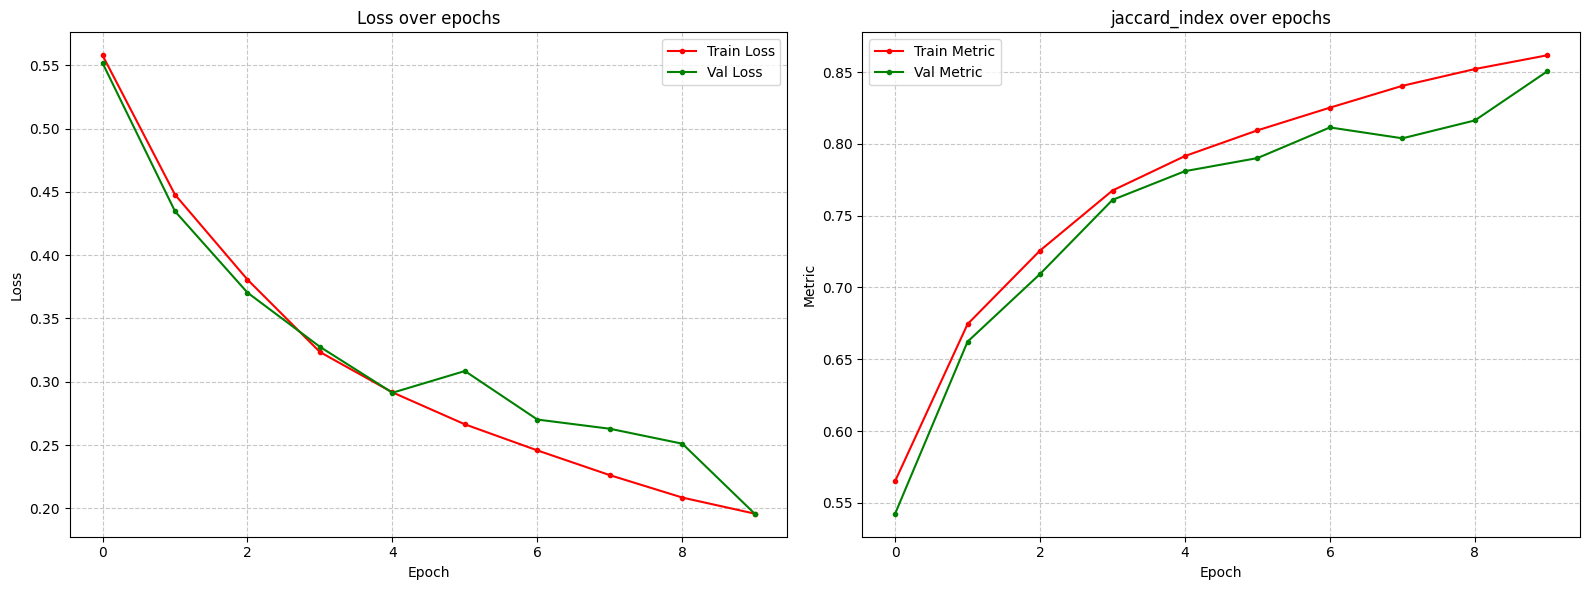

In [25]:
model = UNET(3, 16, 1).to(device)
optimizer = torch.optim.Adam(model.parameters())

model, _, _ = learning_loop(model, optimizer, train_loader, test_loader, criterion, epochs=10)

In [26]:
model.eval();

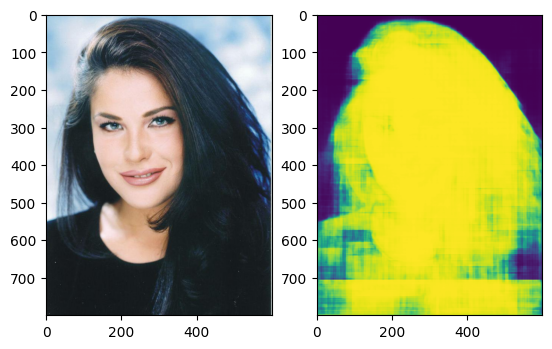

In [27]:
X, _ = train_dataset[15]
with torch.no_grad():
    pred = model(X.to(device).unsqueeze(0))[0].cpu()
show_images(X, nn.functional.sigmoid(pred))

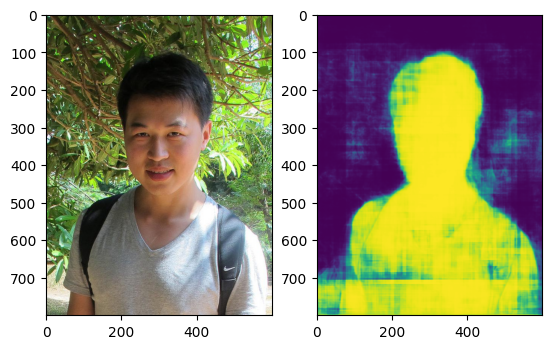

In [28]:
X, _ = test_dataset[15]

with torch.no_grad():
    pred = model(X.to(device).unsqueeze(0))[0].cpu()
show_images(X, nn.functional.sigmoid(pred))

Можно заметить, что на 10 эпохах модель уже неплохо обучилась, но еще допускает шум. Лосс падает, визуально можем оценить качество реализации

Посмотрим на 3 худших (jaccard index) результата, среди тестовых данных

In [29]:
def show_worst_test_cases(model, n):
    test_metrics = []
    with torch.no_grad():
        for i, (X, y) in enumerate(test_dataset):
            pred = model(X.to(device).unsqueeze(0))[0]
            test_metrics.append((jaccard_index(pred, y.to(device)).item(), i))

    idx = [i for _, i in sorted(test_metrics)[:n]]

    with torch.no_grad():
        for i in idx:
            X, _ = test_dataset[i]
            pred = model(X.to(device).unsqueeze(0))[0]
            show_images(X, nn.functional.sigmoid(pred))

    return idx

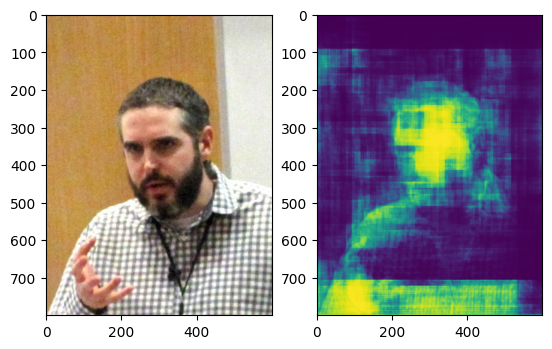

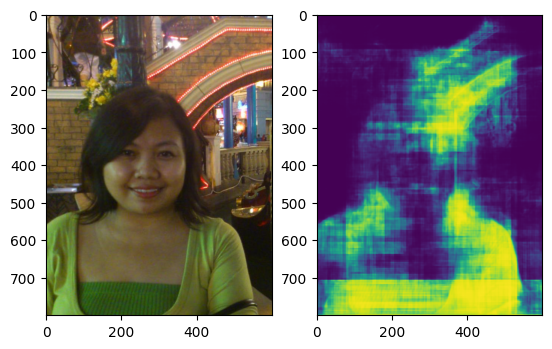

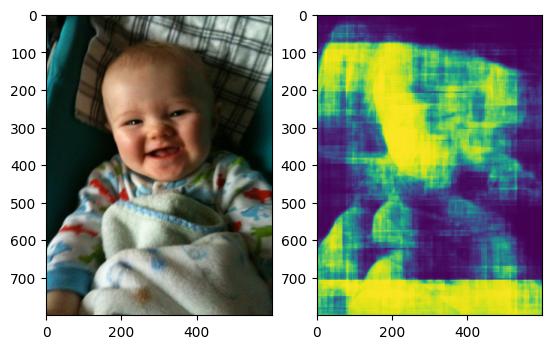

In [30]:
worst_idxs = show_worst_test_cases(model, 3)

## Аугментации тренировочных данных

In [7]:
augmented = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(p=1),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

In [13]:
train_size = int(len(images_path) * 0.8)

test_dataset = Dataset(images=images_path[train_size:], masks=masks_path[train_size:], transform=augmented)
train_dataset = Dataset(images=images_path[:train_size], masks=masks_path[:train_size], transform=augmented)

torch.Size([3, 256, 256])
torch.Size([1, 256, 256])


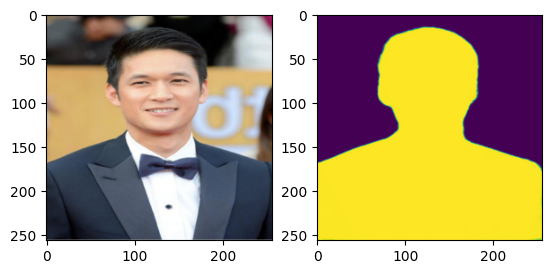

In [100]:
augmented_img, augmented_mask = train_dataset[14]

print(augmented_img.shape)
print(augmented_mask.shape)

show_images(augmented_img, augmented_mask)

In [22]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=True)

Train Loss: 0.0649, Val Loss: 0.0809
Train Metric: 0.9568, Val Metric: 0.9453


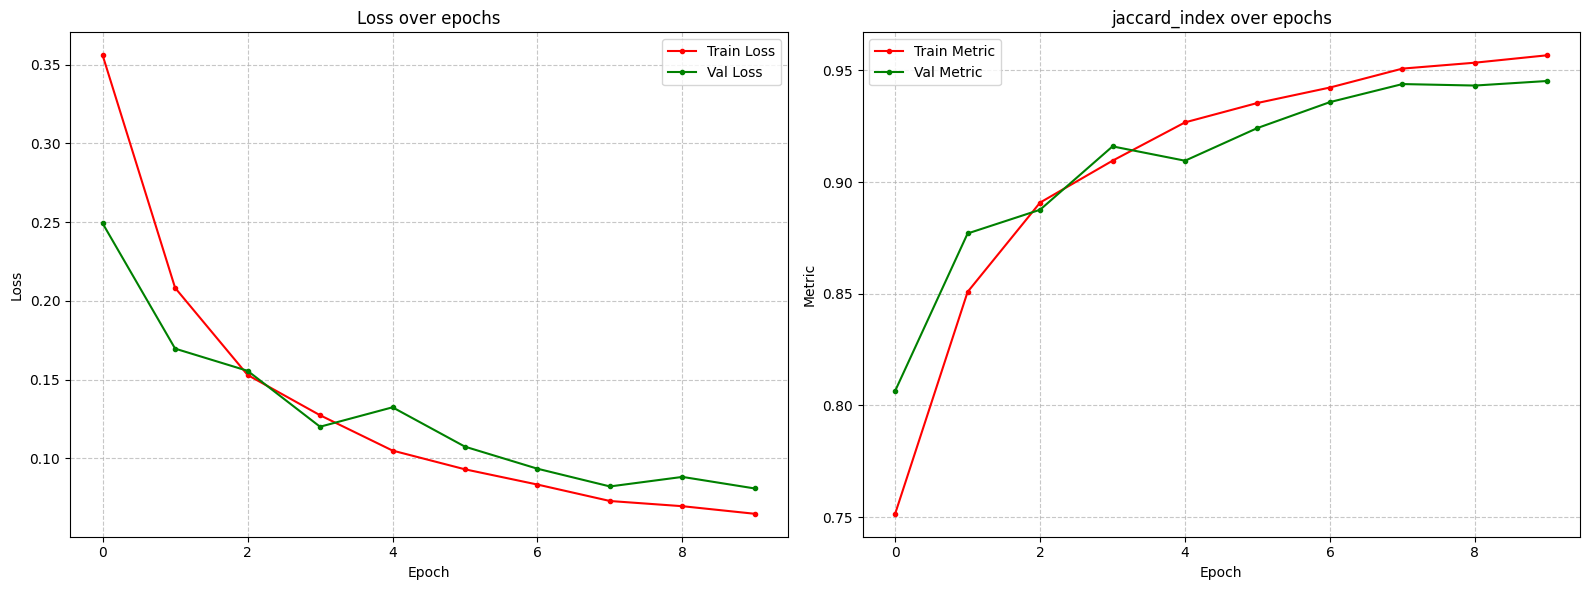

In [102]:
model = UNET(3, 16, 1).to(device)
optimizer = torch.optim.Adam(model.parameters())

model, _, _ = learning_loop(model, optimizer, train_loader, test_loader, criterion, epochs=10)

С аугментацией данных метрики стали выше, а лосс меньше!

## Изменение архитектуры

1. Добавим Dropout, который избавляет модель от переобучения
2. Добавим еще несколько слоев в нейронную сеть

In [16]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=0):
        super(CNNBlock, self).__init__()

        self.seq_block = nn.Sequential(
            nn.Conv2d(
                in_channels, out_channels, kernel_size, stride, padding, bias=False
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.3),
            nn.Conv2d(out_channels, out_channels, kernel_size=1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.seq_block(x)


class CNNBlocks(nn.Module):
    def __init__(self, n_conv, in_channels, out_channels, padding):
          super(CNNBlocks, self).__init__()

          self.layers = nn.ModuleList()
          for _ in range(n_conv):
              self.layers.append(CNNBlock(in_channels, out_channels, padding=padding))
              in_channels = out_channels

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


class Encoder(nn.Module):
    def __init__(self, in_channels, out_channels, padding, n_down=4):
        super(Encoder, self).__init__()

        self.enc_layers = nn.ModuleList()
        for _ in range(n_down):
            self.enc_layers += [CNNBlocks(n_conv=2,
                                          in_channels=in_channels,
                                          out_channels=out_channels,
                                          padding=padding),
                                nn.MaxPool2d(2, 2)
                                ]

            in_channels = out_channels
            out_channels = 2 * out_channels

        self.enc_layers.append(CNNBlocks(n_conv=2,
                                         in_channels=in_channels,
                                         out_channels=out_channels,
                                         padding=padding
                                         ))

    def forward(self, x):
        connections = []
        for layer in self.enc_layers:
            if isinstance(layer, CNNBlocks):
                x = layer(x)
                connections.append(x)
            else:
                x = layer(x)
        return x, connections


class Decoder(nn.Module):
    def __init__(self, in_channels, out_channels, exit_channels, padding, n_up=4):
        super(Decoder, self).__init__()

        self.exit_channels = exit_channels
        self.layers = nn.ModuleList()

        for i in range(n_up):
            self.layers += [nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
                            CNNBlocks(n_conv=2, in_channels=in_channels, out_channels=out_channels, padding=padding)]

            in_channels //= 2
            out_channels //= 2

        self.layers.append(nn.Conv2d(in_channels, self.exit_channels, kernel_size=1, padding=0))

    def forward(self, x, connections):
        connections.pop(-1)
        for layer in self.layers:
            if isinstance(layer, CNNBlocks):
                connections_current = connections.pop(-1)
                dim_4 = connections_current.size(3) - x.size(3)
                dim_3 = connections_current.size(2) - x.size(2)
                if dim_4 != 0 or dim_3 != 0:
                    x = nn.functional.pad(x, [0, dim_4, 0, dim_3])
                x = torch.cat([x, connections_current], dim=1)
                x = layer(x)
            else:
                x = layer(x)
        return x

class NewUNET(nn.Module):
    def __init__(
        self, in_channels, first_out_channels, exit_channels, n_down=4, padding=1
    ):
        super(NewUNET, self).__init__()
        self.encoder = Encoder(in_channels, first_out_channels, padding=padding, n_down=n_down)
        self.decoder = Decoder(first_out_channels * (2 ** n_down),
                               first_out_channels * (2 ** (n_down - 1)),
                               exit_channels, padding=padding, n_up=n_down)

    def forward(self, x):
        enc_out, connections = self.encoder(x)
        return self.decoder(enc_out, connections)

Train Loss: 0.2199, Val Loss: 0.2222
Train Metric: 0.8448, Val Metric: 0.8562


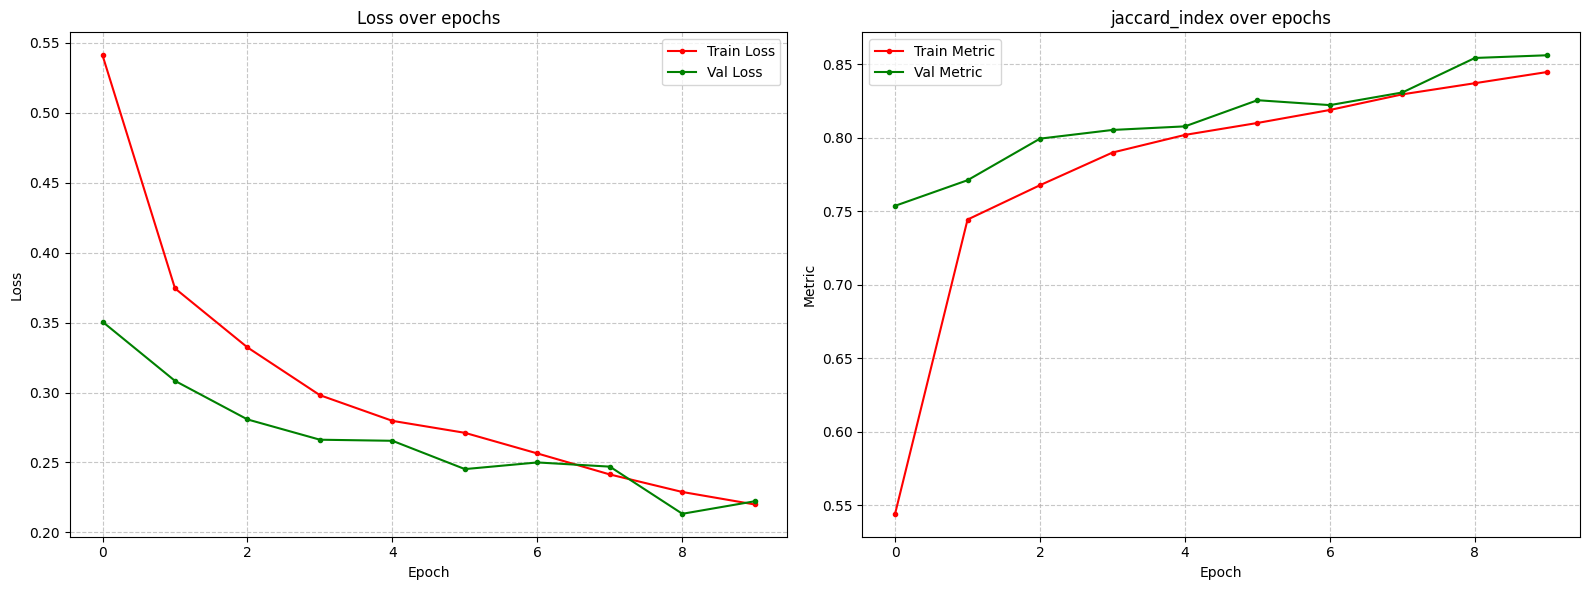

In [23]:
model = NewUNET(3, 16, 1).to(device)
optimizer = torch.optim.Adam(model.parameters())

model, _, _ = learning_loop(
    model, optimizer, train_loader, test_loader, criterion,
    epochs=10
)



Качество модели стало хуже.

## K-Fold

In [28]:
kfold = KFold(n_splits=5)
train_folds, val_folds = [], []
tr_data = train_dataset
for fold,(train_idx,test_idx) in enumerate(kfold.split(tr_data)):
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_idx)

    trainloader = torch.utils.data.DataLoader(
                      tr_data,
                      batch_size=8, sampler=train_subsampler)
    testloader = torch.utils.data.DataLoader(
                      tr_data,
                      batch_size=8, sampler=test_subsampler)
    train_folds.append(trainloader)
    val_folds.append(testloader)

def run_kth_model(k, train_folds=train_folds, val_folds=val_folds):
    t = train_folds[k]
    tt = val_folds[k]
    mod = UNET(3, 16, 1).to(device)
    opt = torch.optim.Adam(mod.parameters())
    final, _, _ = learning_loop(mod, opt, t, tt, criterion)
    return final

Train Loss: 0.0550, Val Loss: 0.1120
Train Metric: 0.9628, Val Metric: 0.9379


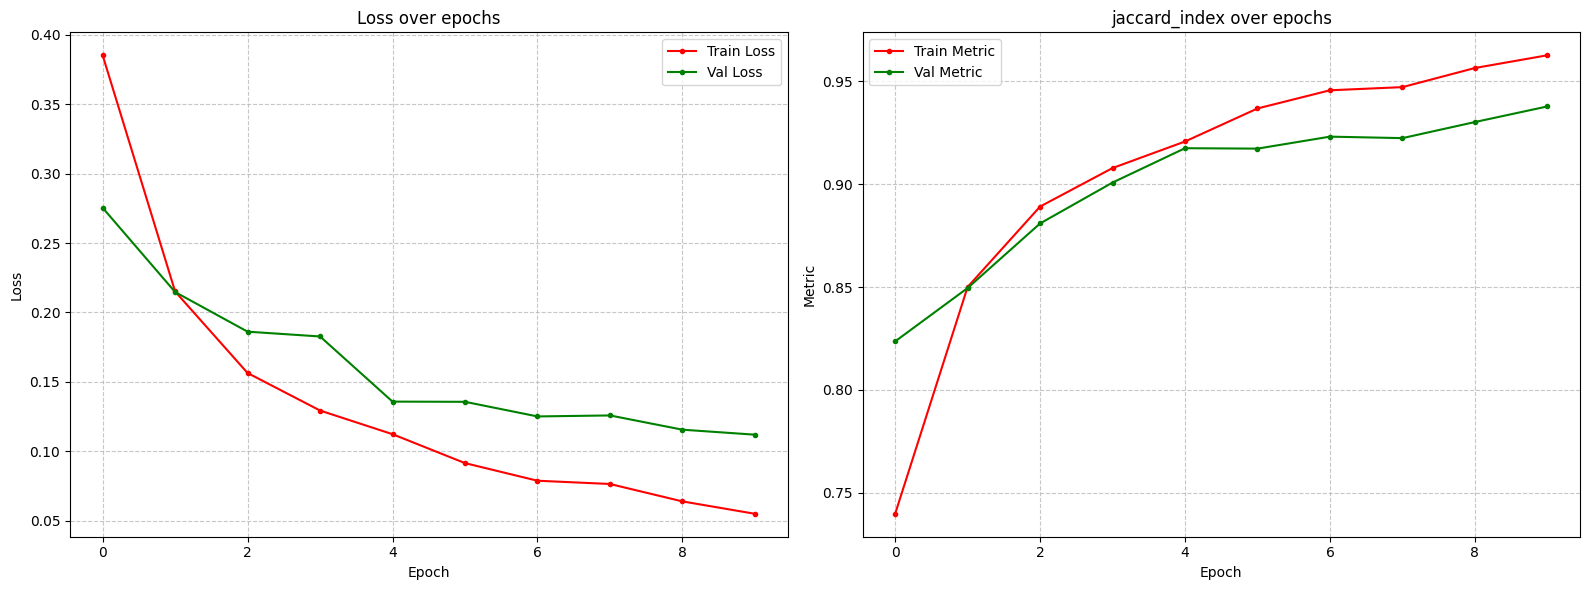

In [31]:
first_model = run_kth_model(0)

Train Loss: 0.0641, Val Loss: 0.0792
Train Metric: 0.9578, Val Metric: 0.9467


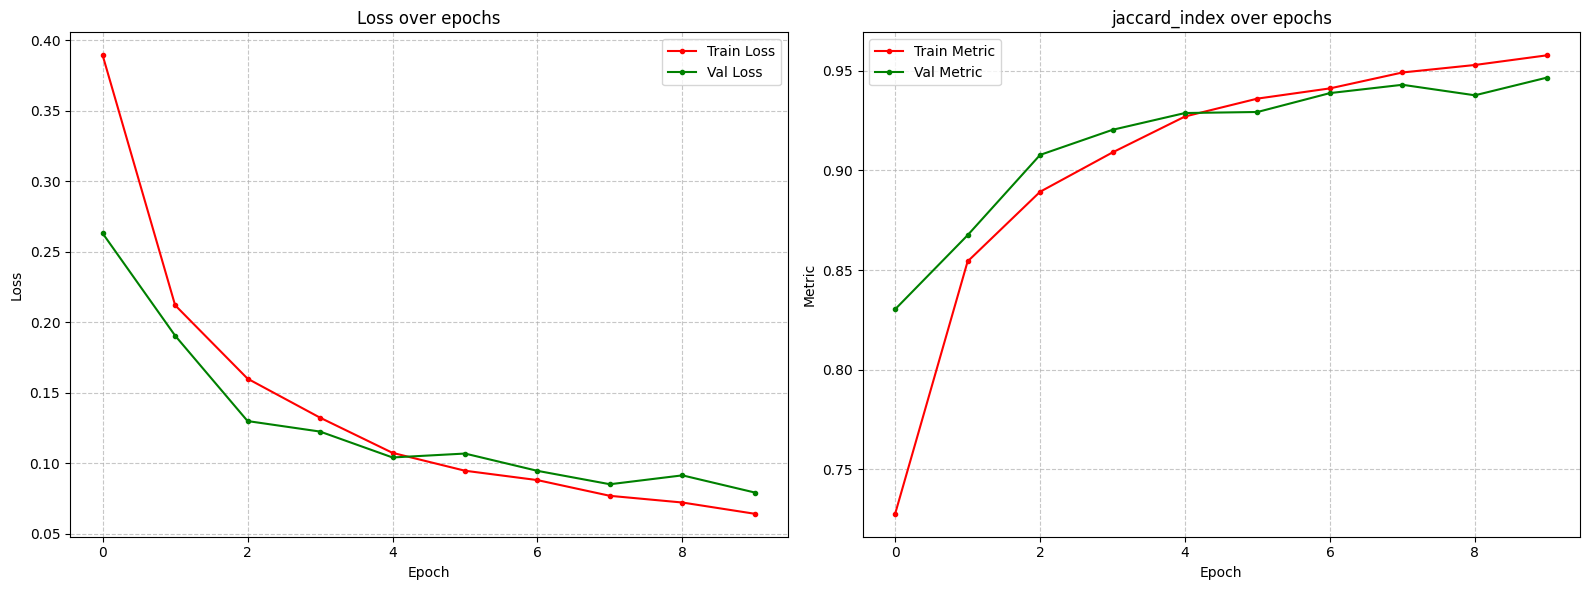

In [32]:
second_model = run_kth_model(1)

Train Loss: 0.0706, Val Loss: 0.0816
Train Metric: 0.9527, Val Metric: 0.9434


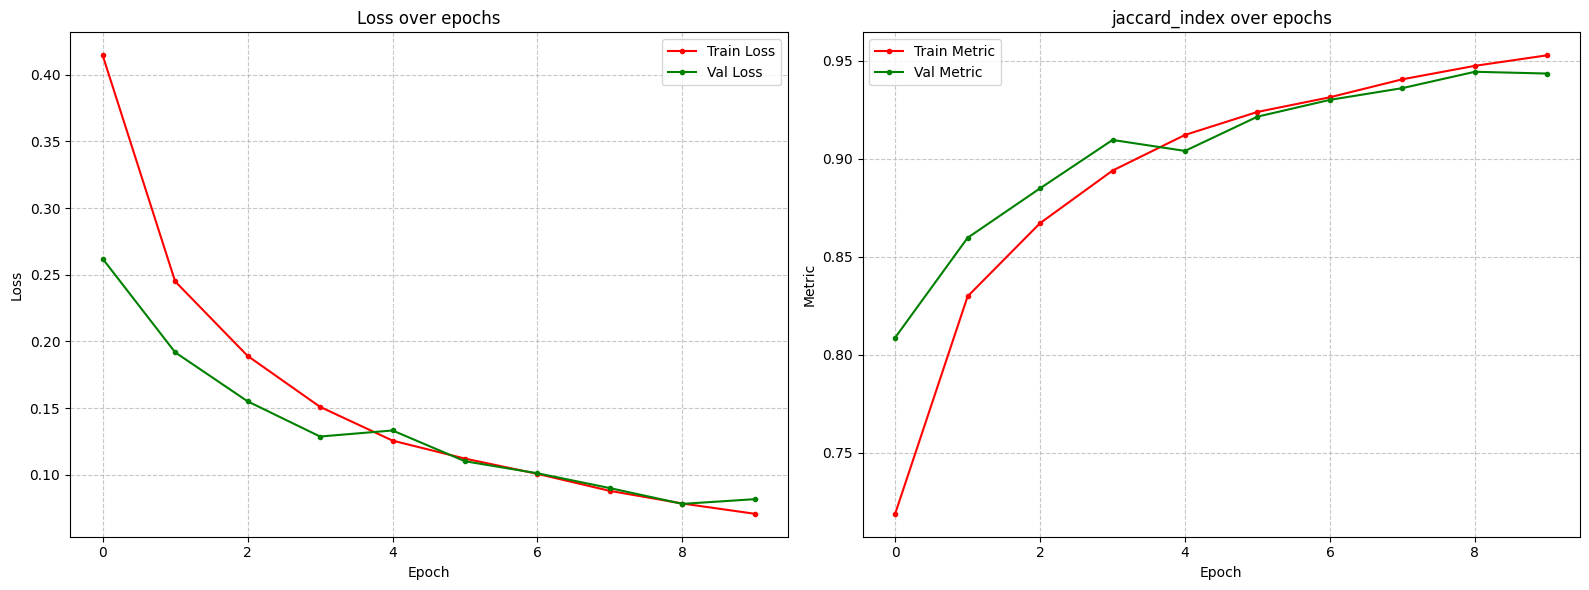

In [33]:
third_model = run_kth_model(2)

Train Loss: 0.0673, Val Loss: 0.0944
Train Metric: 0.9551, Val Metric: 0.9346


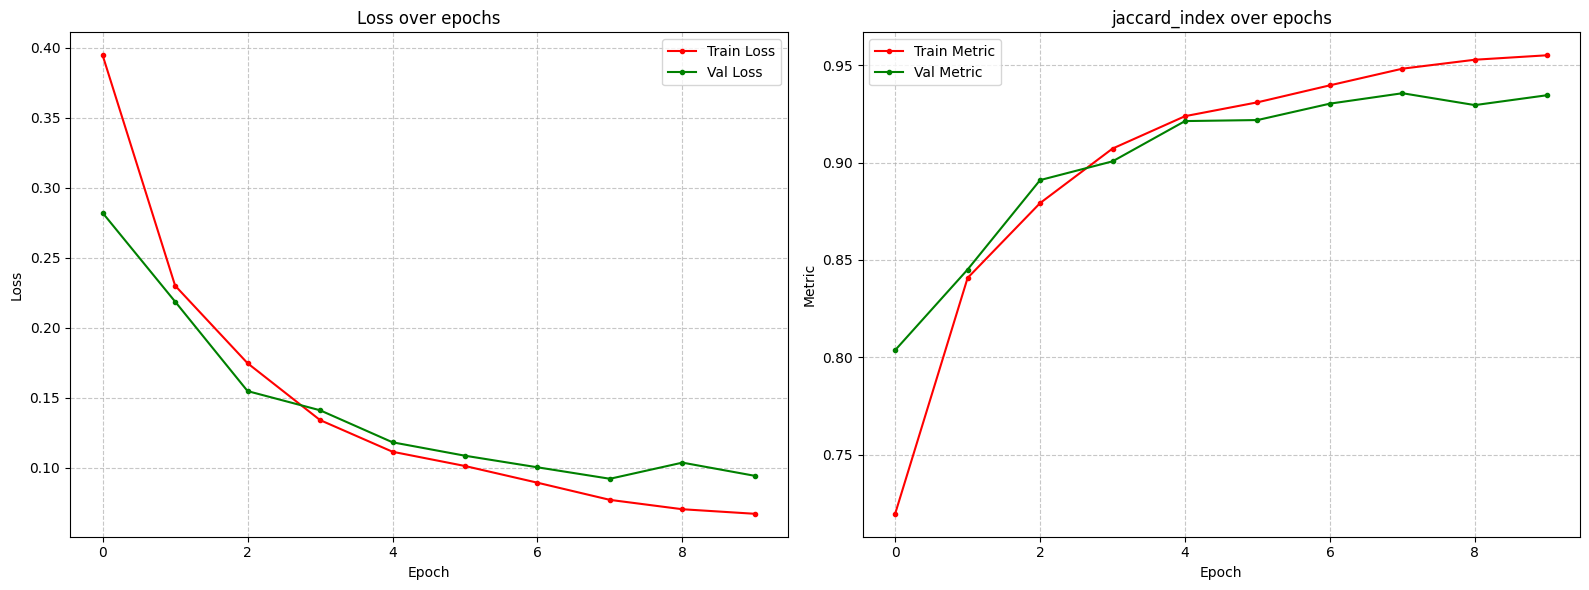

In [34]:
fourth_model = run_kth_model(3)

Train Loss: 0.0576, Val Loss: 0.0670
Train Metric: 0.9630, Val Metric: 0.9571


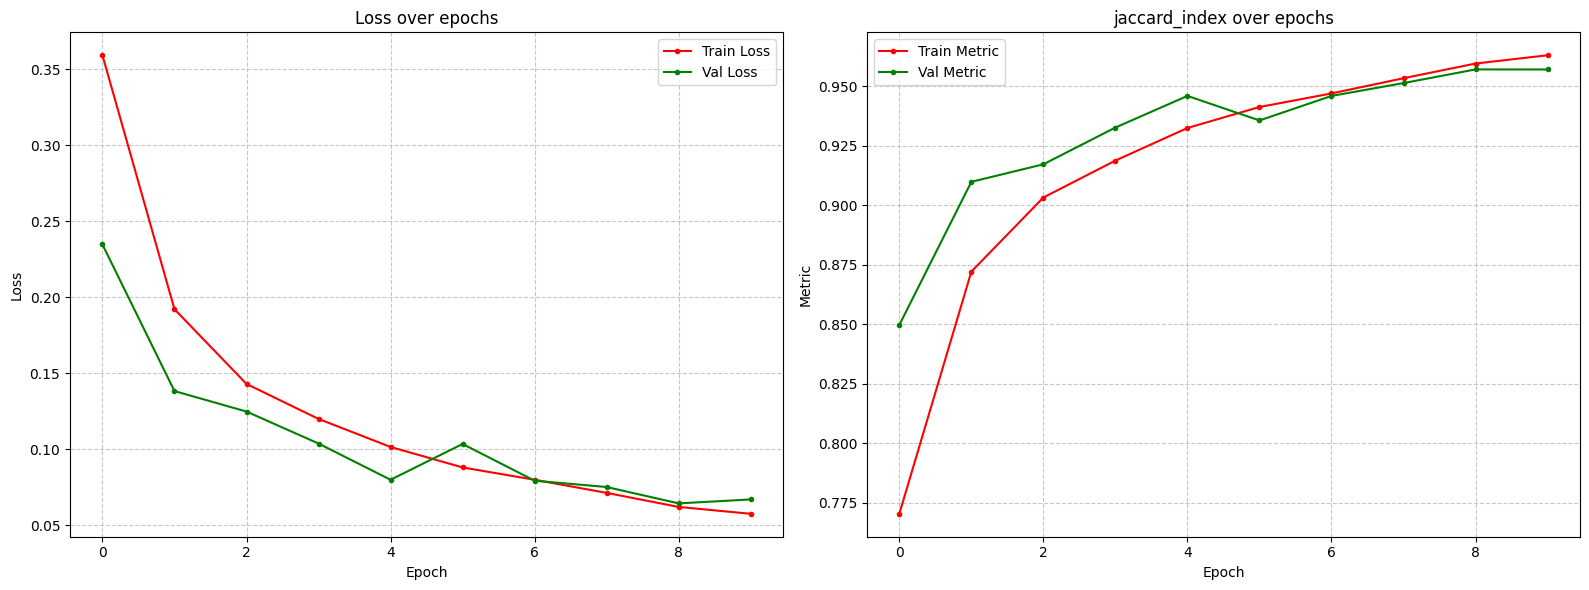

In [35]:
fifth_model = run_kth_model(4)

Качество на обученных на фолдах моделях лучше. Однако разница не сильная, что означает, что наша изначальная модель не переобучилась.